In [1]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import make_grid 
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import os
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import seaborn as sn
import pandas as pd

In [2]:
#access dataset on google drive
from google.colab import drive
drive.mount('/content/drive')
proj_dir = '/content/drive/My Drive/data'
data_dir = '/content/drive/My Drive/data/archive'
classes = os.listdir(data_dir)
print(classes)
# meningioma(1), glioma(2), pituitary tumor(3) 

Mounted at /content/drive
['meningioma', 'glioma', 'pituitary']


In [ ]:
'''
# Check File directory
pituitary_brains = os.listdir(data_dir+"/3")
print('No. of training examples for pituitary tumor samples:', len(pituitary_brains))
print(pituitary_brains[:5])
'''

In [3]:
from torchvision.transforms import ToTensor
data_transform = transforms.Compose([transforms.Grayscale(1), transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=data_transform)

In [4]:
#filtering inappropriate images 
from PIL import Image
'''
path = data_dir+"/pituitary"
for images in os.listdir(path):
    img = Image.open(path+"/"+images)
    if img.width != 512:
        os.remove(path+"/"+images)
'''

'\npath = data_dir+"/pituitary"\nfor images in os.listdir(path):\n    img = Image.open(path+"/"+images)\n    if img.width != 512:\n        os.remove(path+"/"+images)\n'

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) # matplotlib expects 0-dimension to be last. Permute function moves 0-dimention to last dimension for matplotlib

In [5]:
#split into training data, validating data. 

import time
random_seed = time.time()
torch.manual_seed(random_seed)
val_size = 400
test_size = 400
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(2249, 400, 400)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# CNN utilities

def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro, co])
    for i in range (ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck]*kernel)
    return output


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
#architecture of the model
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
            
            nn.Flatten(), 
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3))
        
    def forward(self, xb):
        return self.network(xb)
    

In [11]:
# summarize model prarameters
model = CnnModel()
model
sum([p.numel() for p in model.parameters()])

9646723

In [8]:
# CNN utilities

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [9]:
# Utilities to train on GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
#training on GPU
#create dataloader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, 32, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, 32, num_workers=4, pin_memory=True)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)
model = to_device(CnnModel(), device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
#training process
%%time
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.0175, val_loss: 0.7762, val_acc: 0.6635
Epoch [1], train_loss: 0.6280, val_loss: 0.5436, val_acc: 0.7404
Epoch [2], train_loss: 0.5121, val_loss: 0.4745, val_acc: 0.7981
Epoch [3], train_loss: 0.4622, val_loss: 0.4999, val_acc: 0.7524
Epoch [4], train_loss: 0.4006, val_loss: 0.5316, val_acc: 0.7764
Epoch [5], train_loss: 0.3586, val_loss: 0.3729, val_acc: 0.8365
Epoch [6], train_loss: 0.3130, val_loss: 0.4165, val_acc: 0.8149
Epoch [7], train_loss: 0.2940, val_loss: 0.3479, val_acc: 0.8630
Epoch [8], train_loss: 0.2185, val_loss: 0.3273, val_acc: 0.8510
Epoch [9], train_loss: 0.1946, val_loss: 0.2956, val_acc: 0.8678
Epoch [10], train_loss: 0.1530, val_loss: 0.3026, val_acc: 0.8894
Epoch [11], train_loss: 0.1355, val_loss: 0.2908, val_acc: 0.8798
Epoch [12], train_loss: 0.0997, val_loss: 0.3620, val_acc: 0.8726
Epoch [13], train_loss: 0.0847, val_loss: 0.2707, val_acc: 0.9135
Epoch [14], train_loss: 0.0577, val_loss: 0.2774, val_acc: 0.9014
CPU times: user 2min

In [22]:
# evaluate on test dataset
test_dl = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_dl)
result

{'val_loss': 0.20039460062980652, 'val_acc': 0.9278846383094788}

[]

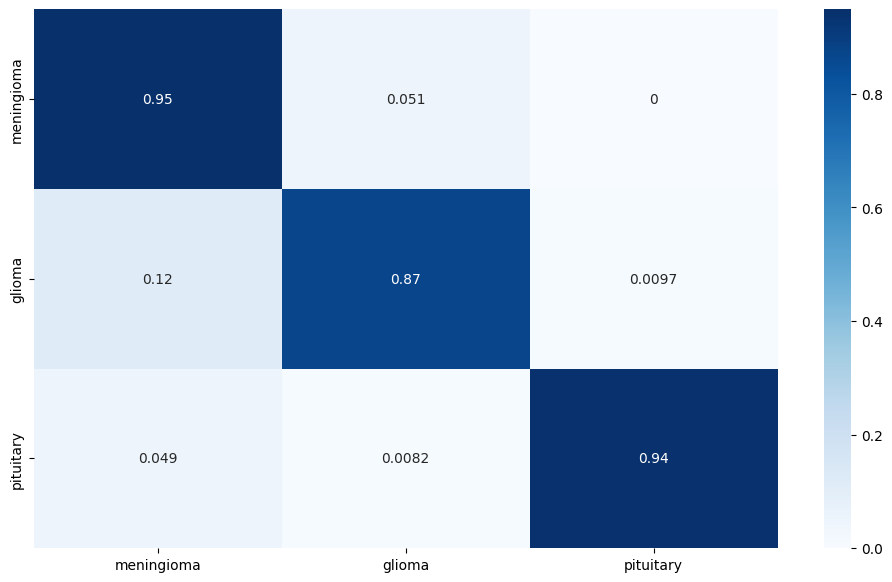

In [26]:
# Plot Confusion Matrix for test dataset 

expected = []
predicted = []

for inputs, labels in test_ds:
  expected.append(dataset.classes[labels])
  predicted.append(predict_image(inputs, model))

cf_matrix = confusion_matrix(expected,predicted)
classes = ('meningioma', 'glioma', 'pituitary')
lb_matx = pd.DataFrame(normalize(cf_matrix, axis=1, norm='l1'), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(lb_matx, annot=True, cmap="Blues")
plt.plot()

In [57]:
# Load additional test dataset
'''
This is a separate brain imaging dataset. 
We want to test the model performance on a totally different dataset and see whether the performance is consistent.
'''
additional_test_dataset = datasets.ImageFolder(proj_dir+'/test', transform=data_transform)
additional_test_loader = DeviceDataLoader(DataLoader(additional_test_dataset, 32), device)
#filter images with small size
'''
path = proj_dir+'/test/meningioma'
for images in os.listdir(path):
    img = Image.open(path+"/"+images)
    if img.width != 512:
        os.remove(path+"/"+images)
'''

'\npath = proj_dir+\'/test/meningioma\'\nfor images in os.listdir(path):\n    img = Image.open(path+"/"+images)\n    if img.width != 512:\n        os.remove(path+"/"+images)\n'

In [29]:
# Evaluate on test dataset

additional_test_loader_result = evaluate(model, additional_test_loader )
additional_test_loader_result

{'val_loss': 1.5984712839126587, 'val_acc': 0.7975000143051147}

[]

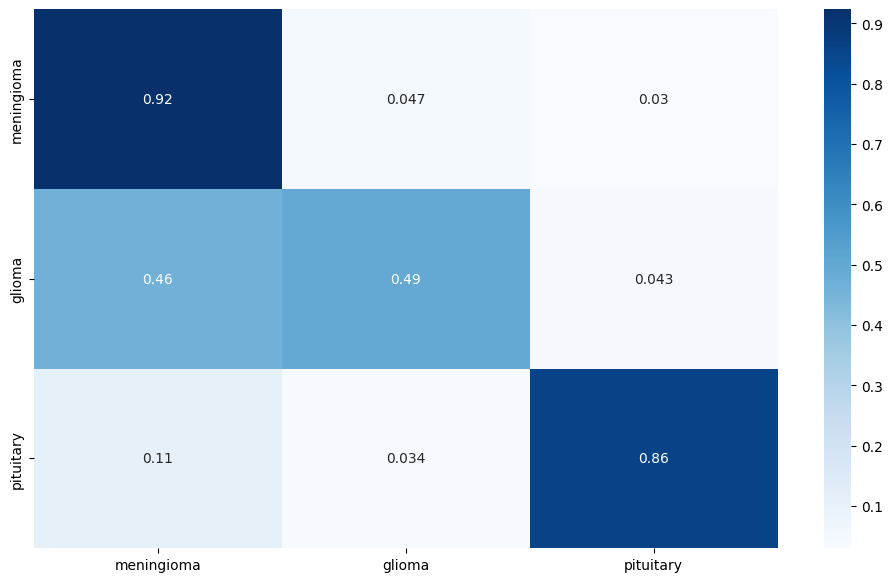

In [30]:
# Confusion matrix on the additional Test dataset
expected = []
predicted = []

for inputs, labels in additional_test_dataset:
  expected.append(dataset.classes[labels])
  predicted.append(predict_image(inputs, model))

cf_matrix = confusion_matrix(expected,predicted)
classes = ('meningioma', 'glioma', 'pituitary')
lb_matx = pd.DataFrame(normalize(cf_matrix, axis=1, norm='l1'), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(lb_matx, annot=True, cmap="Blues")
plt.plot()

In [31]:
# Save the current model
torch.save(model.state_dict(), '10cnn_1.pth')

In [15]:
# reassign dataset for cross validation
test_size=500
train_size=len(dataset)-test_size
train_ds,test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)
# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
# test_dl = DataLoader(test_ds, 32, num_workers=2, pin_memory=True)
# device = get_default_device()
# train_dl = DeviceDataLoader(train_dl, device)
# test_dl = DeviceDataLoader(test_dl, device)

(2549, 500)

In [18]:
 torch.cuda.empty_cache() 

In [19]:
from sklearn.model_selection import KFold
'''
We want to see what if we train a model with everthing in one dataset, 
and see if that promotes the performance on the additional dataset.
To avoid overfitting, we are using cross validations on the original dataset.
'''


kfold = KFold(n_splits=5, shuffle=True)
crossval = []
modelList= []

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_ds)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Initialize a new Model
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=2, sampler=train_subsampler, pin_memory=True)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=2, sampler=test_subsampler, pin_memory=True)
    
    device = get_default_device()
    train_dl = DeviceDataLoader(trainloader, device)
    val_dl = DeviceDataLoader(testloader, device)
    newModel = to_device(CnnModel(), device)

    num_epochs = 10
    lr = 0.0001
    opt_func = torch.optim.Adam
    # training
    history = fit(num_epochs, lr, newModel, train_dl, val_dl, opt_func)
    # Save performance and Model
    crossval.append(history)
    modelList.append(newModel)
    

FOLD 0
--------------------------------
Epoch [0], train_loss: 0.9928, val_loss: 0.9497, val_acc: 0.5590
Epoch [1], train_loss: 0.8648, val_loss: 0.7705, val_acc: 0.6141
Epoch [2], train_loss: 0.6870, val_loss: 0.5636, val_acc: 0.6995
Epoch [3], train_loss: 0.5525, val_loss: 0.5420, val_acc: 0.7194
Epoch [4], train_loss: 0.5234, val_loss: 0.5505, val_acc: 0.7447
Epoch [5], train_loss: 0.4786, val_loss: 0.5145, val_acc: 0.7491
Epoch [6], train_loss: 0.4299, val_loss: 0.4947, val_acc: 0.7628
Epoch [7], train_loss: 0.4060, val_loss: 0.4565, val_acc: 0.7939
Epoch [8], train_loss: 0.3718, val_loss: 0.4407, val_acc: 0.7919
Epoch [9], train_loss: 0.3493, val_loss: 0.3774, val_acc: 0.8238
FOLD 1
--------------------------------
Epoch [0], train_loss: 1.0044, val_loss: 1.0032, val_acc: 0.5655
Epoch [1], train_loss: 0.9520, val_loss: 0.8833, val_acc: 0.5999
Epoch [2], train_loss: 0.7587, val_loss: 0.6430, val_acc: 0.6822
Epoch [3], train_loss: 0.6692, val_loss: 0.5975, val_acc: 0.6992
Epoch [4],

In [33]:
torch.save(modelList[3].state_dict(), "cv_bestModel.pth")

In [48]:
# Plotting utilities
def plot_accuracies(multiHistory):
    accuracies=[]
    for history in multiHistory:
      accuracies.append([x['val_acc'] for x in history])
    print(accuracies)
    for i,val in enumerate(accuracies):
      plt.plot(val, '-x', label=str(i))
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.plot()
    

def plot_losses(multiHistory):
    train_losses, val_losses = [], []
    for history in multiHistory:
      train_losses.append([x['train_loss'] for x in history])
      val_losses.append([x['val_loss'] for x in history])
    for i,val in enumerate(train_losses):
      plt.plot(val, '-x', label="train"+str(i))
    for i,val in enumerate(val_losses):
      plt.plot(val, '-o', label="val"+str(i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs')

[[0.5589843988418579, 0.614062488079071, 0.6994791626930237, 0.7194010615348816, 0.7446614503860474, 0.7490885257720947, 0.7627604007720947, 0.7938802242279053, 0.7919270992279053, 0.8238281011581421], [0.5654947757720947, 0.5998697876930237, 0.6821614503860474, 0.69921875, 0.744921863079071, 0.7100260257720947, 0.7572916746139526, 0.7803385257720947, 0.756640613079071, 0.6350260376930237], [0.5824218988418579, 0.6630208492279053, 0.7192708253860474, 0.7345051765441895, 0.757031261920929, 0.7613281011581421, 0.7509114742279053, 0.7914062738418579, 0.8217447996139526, 0.8170573115348816], [0.5412760376930237, 0.5903645753860474, 0.6510416865348816, 0.743359386920929, 0.760937511920929, 0.6509114503860474, 0.7358072996139526, 0.7904947996139526, 0.6997395753860474, 0.8059895634651184], [0.5501077771186829, 0.5811557173728943, 0.6856815814971924, 0.7275053858757019, 0.7505388259887695, 0.722993016242981, 0.774784505367279, 0.748383641242981, 0.8224003314971924, 0.8251616358757019]]


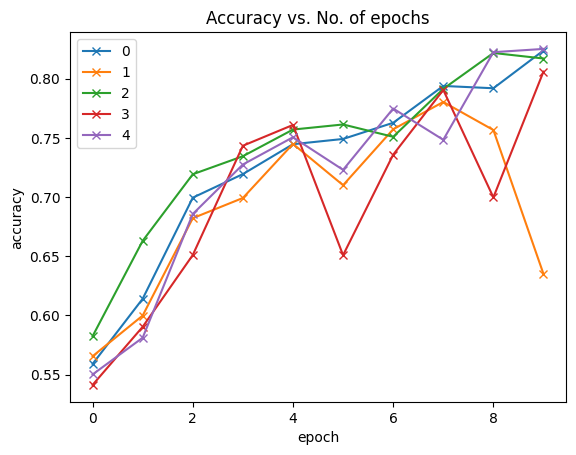

In [40]:
plot_accuracies(crossval)

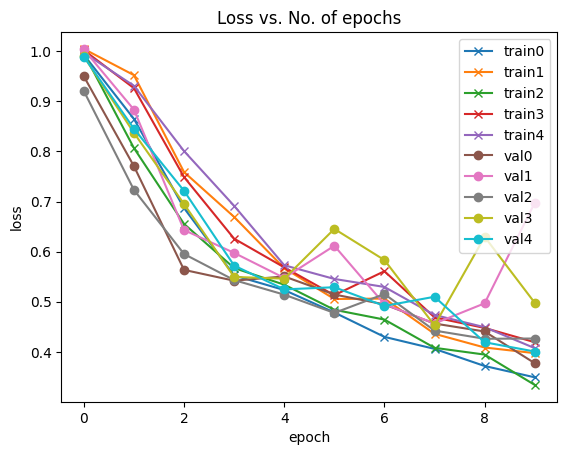

In [49]:
plot_losses(crossval)

In [ ]:
#save the current model
'''
torch.save(model.state_dict(), '10cnn.pth')
model2 = to_device(CnnModel(), device)
model2.load_state_dict(torch.load('10cnn.pth'))
'''

In [50]:
# Evaluate on test dataset
test_dl = DeviceDataLoader(DataLoader(test_ds, 32), device)
test_dl_result = evaluate(modelList[4], test_dl)
test_dl_result

{'val_loss': 0.38093721866607666, 'val_acc': 0.8121093511581421}

In [51]:
test_dl_result = evaluate(modelList[0], test_dl)
test_dl_result

{'val_loss': 0.2984903156757355, 'val_acc': 0.8726562261581421}

[]

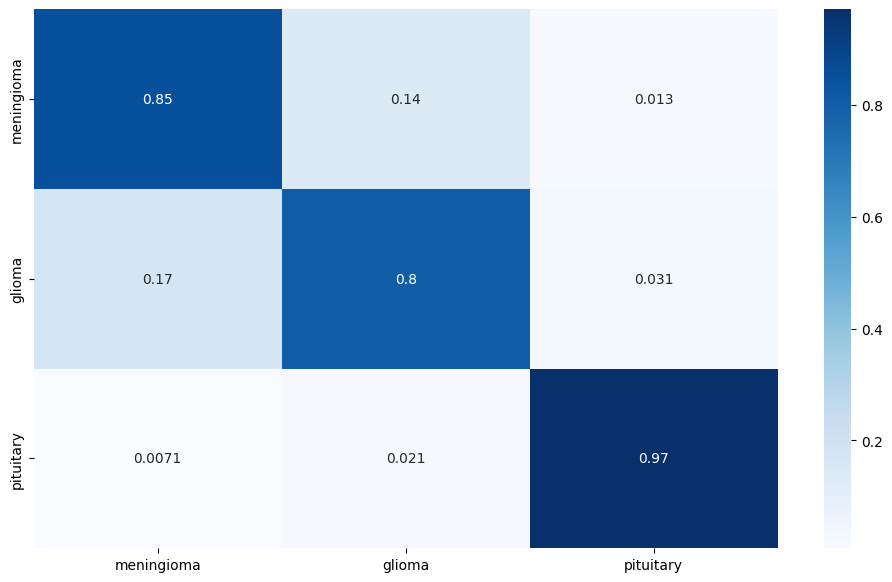

In [54]:
# Confusion Matrix on original dataset
expected = []
predicted = []

for inputs, labels in test_ds:
  expected.append(dataset.classes[labels])
  predicted.append(predict_image(inputs, modelList[0]))

cf_matrix = confusion_matrix(expected,predicted)
classes = ('meningioma', 'glioma', 'pituitary')
lb_matx = pd.DataFrame(normalize(cf_matrix, axis=1, norm='l1'), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(lb_matx, annot=True, cmap="Blues")
plt.plot()

In [58]:
# Evaluate on additional test dataset
result = evaluate(modelList[0], additional_test_loader)
result

{'val_loss': 0.7925165295600891, 'val_acc': 0.7537500262260437}

[]

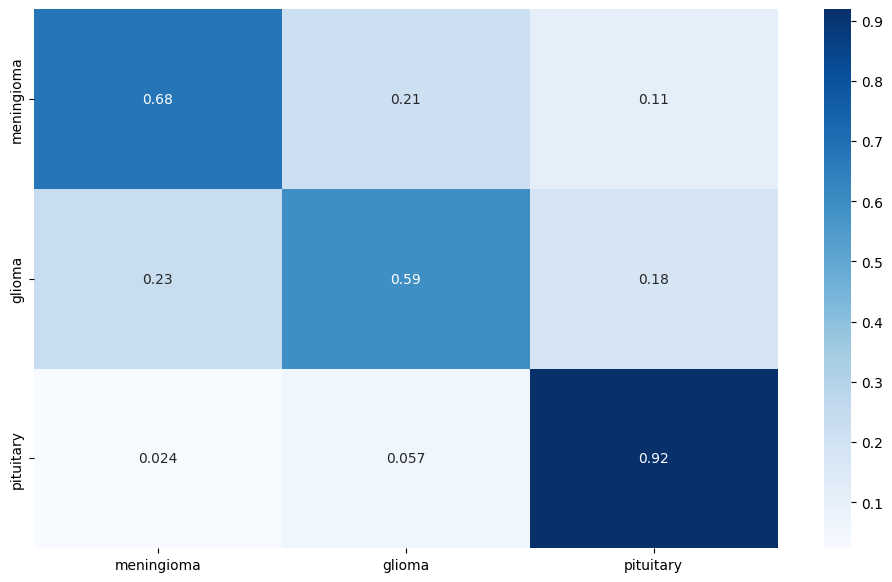

In [63]:

#Confusion matrix on new dataset
expected = []
predicted = []

for inputs, labels in additional_test_dataset:
  expected.append(dataset.classes[labels])
  predicted.append(predict_image(inputs, modelList[0]))

cf_matrix = confusion_matrix(expected,predicted)
lb_matx = pd.DataFrame(normalize(cf_matrix, axis=1, norm='l1'), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(lb_matx, annot=True, cmap="Blues")
plt.plot()

In [ ]:
'''
'''